In [24]:
## import libraries
import h5py
import numpy as np
from PIL import Image
import glob
import time
import matplotlib.pyplot as plt
import logging
from cil.utilities.display import show2D
from cil.recon import FDK
import os
import imageio
from cil.framework import AcquisitionGeometry, ImageGeometry
from cil.plugins.astra import FBP, ProjectionOperator
from cil.utilities.jupyter import islicer
from cil.optimisation.algorithms import PDHG, FISTA, ISTA, SPDHG
from cil.optimisation.utilities import RandomSampling
from cil.optimisation.functions import L2NormSquared, LeastSquares, SGFunction, SAGAFunction, BlockFunction
from cil.optimisation.operators import BlockOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.processors import TransmissionAbsorptionConverter
import zarr
import dask
from scipy.fftpack import fftshift, ifftshift, fft, ifft
from cil.optimisation.utilities import OptimalityDistance
import pywt
import numpy.matlib
from ProxSkip import ProxSkip
from SVRGFunction import SVRGFunction
from cil.optimisation.utilities import RSE, MSE, MAE, PSNR, MetricsDiagnostics, StatisticsDiagnostics, AlgorithmDiagnostics

### Load 3D Dataset

In [2]:
sino1 = zarr.load("NiPd_spent_01_microct_rings_removed.zarr")
print(sino1.shape)

vertical , num_angles, horizontal = sino1.shape

angles_list = np.linspace(0, np.pi, num_angles)
ag = AcquisitionGeometry.create_Parallel3D().\
        set_panel([horizontal,vertical]).\
        set_angles(angles_list, angle_unit="radian").\
        set_labels(['vertical','angle','horizontal'])
ig = ag.get_ImageGeometry()
print(ag.shape)

sino_cil = ag.allocate()
sino_cil.fill(sino1)

### Get 2D slice

In [7]:
data2D = sino_cil.get_slice(vertical=350)
ag2D = data2D.geometry
ig2D = ag2D.get_ImageGeometry()

### Regulariser

In [8]:
alpha = 0.3
G = alpha * FGP_TV(max_iteration = 100, device="gpu") 

### Fidelity

In [9]:
A = ProjectionOperator(ig2D, ag2D, device="gpu")
fidelity = LeastSquares(A=A, b=data2D, c=0.5)

### Algo (1000 iterations)

In [10]:
step_size_fista = 1./fidelity.L
initial = ig2D.allocate()

fista_1000 = FISTA(initial = initial, f = fidelity, step_size = step_size_fista, g=G, 
            update_objective_interval = 100, 
            max_iteration = 1000)
fista_1000.run(verbose=1)

     Iter   Max Iter  Time(s)/Iter            Objective
        0       1000         0.000          8.17946e+02
      100       1000         0.127          2.77418e+01
      200       1000         0.134          2.77402e+01
      300       1000         0.136          2.77402e+01
      400       1000         0.137          2.77402e+01
      500       1000         0.138          2.77402e+01
      600       1000         0.138          2.77402e+01
      700       1000         0.138          2.77402e+01
      800       1000         0.138          2.77402e+01
      900       1000         0.138          2.77402e+01
     1000       1000         0.139          2.77402e+01
-------------------------------------------------------
Stop criterion has been reached.



### Compute Distance from Optimal solution: Root Squared Error (RSE)

In [12]:
cb1 = MetricsDiagnostics(reference_image = fista_1000.solution, 
                         verbose=1, metrics_dict={'rse':RSE})  

fista_100_metrics = FISTA(initial = initial, f = fidelity, step_size = step_size_fista, g=G, 
            update_objective_interval = 20, 
            max_iteration = 100)
fista_100_metrics.run(verbose=1, callback=[cb1])

     Iter   Max Iter  Time(s)/Iter            Objective                 rse
        0        100         0.000          8.17946e+02         8.40131e-02
       20        100         0.134          2.88788e+01         2.37356e-02
       40        100         0.134          2.78383e+01         9.32892e-03
       60        100         0.136          2.77534e+01         3.77138e-03
       80        100         0.137          2.77436e+01         1.90112e-03
      100        100         0.138          2.77418e+01         1.28395e-03
---------------------------------------------------------------------------
Stop criterion has been reached.



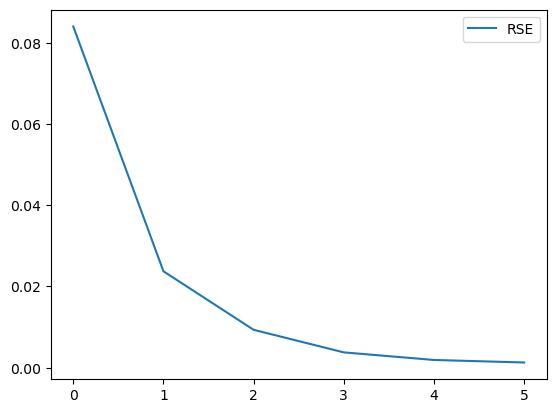

In [14]:
plt.figure()
plt.plot(fista_100_metrics.rse, label="RSE")
plt.legend()
plt.show()

### Compute RSE and MSE

In [18]:
cb1 = MetricsDiagnostics(reference_image = fista_1000.solution, verbose=1, 
                         metrics_dict={'rse':RSE, 'mse':MSE})   

fista_100_metrics = FISTA(initial = initial, f = fidelity, step_size = step_size_fista, g=G, 
            update_objective_interval = 20, 
            max_iteration = 100)
fista_100_metrics.run(verbose=1, callback=[cb1])

     Iter   Max Iter  Time(s)/Iter            Objective                 rse                  mse
        0        100         0.000          8.17946e+02         8.40131e-02          1.46125e-08
       20        100         0.130          2.88788e+01         2.37356e-02          1.16636e-09
       40        100         0.132          2.78383e+01         9.32892e-03          1.80174e-10
       60        100         0.135          2.77534e+01         3.77138e-03          2.94463e-11
       80        100         0.137          2.77436e+01         1.90112e-03          7.48256e-12
      100        100         0.138          2.77418e+01         1.28395e-03          3.41291e-12
------------------------------------------------------------------------------------------------
Stop criterion has been reached.



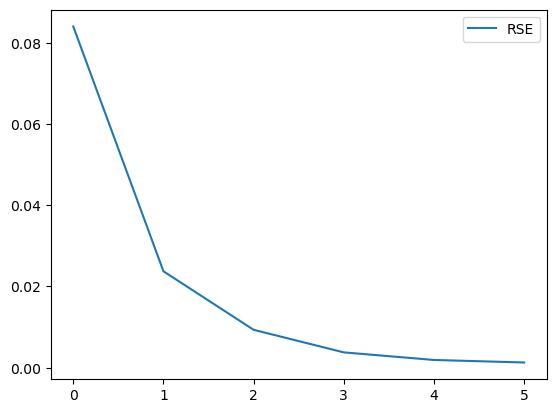

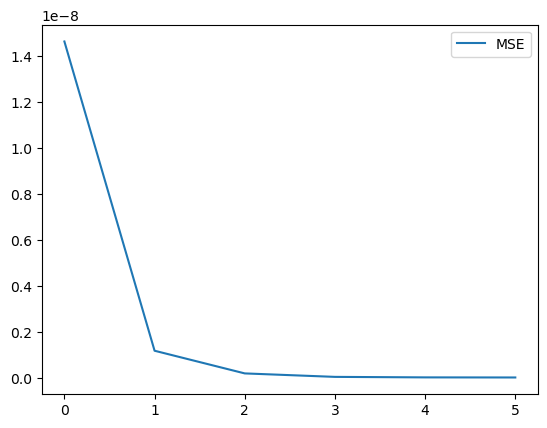

In [19]:
plt.figure()
plt.plot(fista_100_metrics.rse, label="RSE")
plt.legend()
plt.show()

plt.figure()
plt.plot(fista_100_metrics.mse, label="MSE")
plt.legend()
plt.show()

### Compute Metrics + Statistics: MAE, MEAN, MAX

In [20]:
cb1 = MetricsDiagnostics(reference_image = fista_1000.solution, verbose=1, 
                         metrics_dict={'mae':MAE})   

cb2 = StatisticsDiagnostics(verbose=1, statistics_dict={'mean': (lambda x: x.mean()),
                                                       'max': (lambda x: x.max())}) 

fista_100_statistics = FISTA(initial = initial, f = fidelity, step_size = step_size_fista, g=G, 
            update_objective_interval = 20, 
            max_iteration = 100)
fista_100_statistics.run(verbose=1, callback=[cb1, cb2])

     Iter   Max Iter  Time(s)/Iter            Objective                 mae                 mean                  max
        0        100         0.000          8.17946e+02         6.51097e-05          0.00000e+00          0.00000e+00
       20        100         0.130          2.88788e+01         1.50930e-05          6.52029e-05          3.96667e-04
       40        100         0.132          2.78383e+01         4.24351e-06          6.51218e-05          6.81486e-04
       60        100         0.135          2.77534e+01         1.62335e-06          6.51099e-05          8.69920e-04
       80        100         0.137          2.77436e+01         9.36372e-07          6.51100e-05          9.34145e-04
      100        100         0.138          2.77418e+01         6.10000e-07          6.51094e-05          9.46776e-04
---------------------------------------------------------------------------------------------------------------------
Stop criterion has been reached.



### Monitor with Weights and Biases (wandb)

In [27]:
import wandb
class WandbMonitor(AlgorithmDiagnostics):
    
    def __init__(self, project_name, run_name, config, monitor,verbose=1):

        run = wandb.init(
            # Set the project where this run will be logged
            project=project_name, name = run_name,
            # Track hyperparameters and run metadata
            config=config)            

        self.verbose = verbose
        self.monitor = monitor

           
    def __call__(self, algo):

        attribute_values = {attribute: getattr(algo, attribute)[-1] for attribute in self.monitor}
        wandb.log(attribute_values)
        
    def callback_header(self):
        return ""  

    def callback_info_iter(self):
        return ""  

In [29]:
cb1 = MetricsDiagnostics(reference_image = fista_1000.solution, verbose=1, 
                         metrics_dict={'rse':RSE})   

cb2 = StatisticsDiagnostics(verbose=1, statistics_dict={'mean': (lambda x: x.mean()),
                                                       'max': (lambda x: x.max())})

project_name = "a4i_runs_4"
config={"algorithm":"fista"}

cb3 = WandbMonitor(project_name = project_name, run_name = "FISTA_wandb", 
                       config=config, monitor=['objective','rse','max'])    

fista_100_statistics = FISTA(initial = initial, f = fidelity, step_size = step_size_fista, g=G, 
            update_objective_interval = 5, 
            max_iteration = 1000)
fista_100_statistics.run(verbose=0, callback=[cb1, cb2, cb3])

max,▁▄▆▇██
objective,█▁▁▁▁▁
rse,█▃▂▁▁▁
max,0.00095
objective,27.74182
rse,0.00128


In [ ]:
    # cb2 = WandbMonitor(project_name = project_name, run_name = "SPDHG_4_gamma_{}".format(gamma), 
    #                    config=config, monitor=['objective','RSE'])    